<a href="https://colab.research.google.com/github/Dkepffl/Advanced_Analysis/blob/main/Transformer/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import Packages**

In [609]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader

import numpy as np

## **Data loader**

In [610]:
# data loader
path = './datasets/'

# Data transform Setting
transform = transforms.Compose([transforms.ToTensor()]) # Tensor 변환. 다른 전처리X

# Load data
train_data = CIFAR100(root=path,train=True,transform=transform,download=True)
test_data = CIFAR100(root=path,train=False,transform=transform,download=True)

batch_size = 100

train_loader = DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True,num_workers=0)
test_loader = DataLoader(dataset=test_data,batch_size=batch_size,shuffle=False,num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


### **Image 확인용**

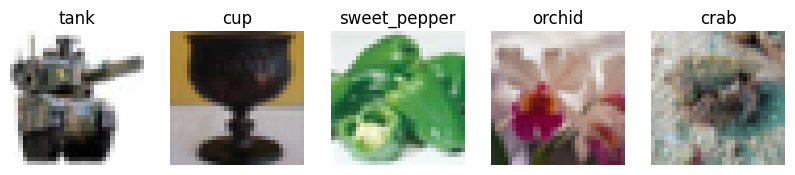

In [643]:
import matplotlib.pyplot as plt

np.random.seed(42)
random_nums = [np.random.randint(1, 2001) for i in range(5)]

plt.figure(figsize=(10, 2))

for i in range(len(random_nums)):
    plt.subplot(1, 5, i+1) # 5번 번갈아가며 서브플롯 생성
    y = train_loader.dataset[random_nums[i]][0]
    plt.imshow(np.transpose(y, (1,2,0))) # 이미지 데이터를 (C, H, W)에서 (H, W, C) 차원으로 변환, 랜덤 번호의 이미지 출력
    plt.title(train_data.classes[train_loader.dataset[random_nums[i]][1]])
    plt.axis('off')

### **Data shape**

In [612]:
input_shape = train_data[0][0].shape # 출력 결과 : [3, 32, 32]
output_shape = len(train_data.classes) # 출력 결과 : 100

## **Transformer 구현**

In [613]:
##########################################
#### there is nothing to do upto here ####
##########################################

### **Positional Encoding**
```python
# argument 정리
pe = PositionalEncoding(device, max_len, d_model)
pos_emb = pe(x)
```
[Jonas Gehring, Michael Auli, David Grangier, Denis Yarats, and Yann N. Dauphin. Convolu
tional sequence to sequence learning. arXiv preprint arXiv:1705.03122v2, 2017.](https://arxiv.org/pdf/1705.03122)

In [614]:
# refer to Section 3.5 in the paper
class PositionalEncoding(nn.Module):
    def __init__(self, device, max_len=512, d_model=16):
        super().__init__()

        self.device = device
        # max_len만큼 만들고 x의 seq_len만큼 잘라서 사용
        self.pos_enc = torch.zeros(max_len, d_model,requires_grad=False, device=device)

        # Position Encoding Matrix
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(-1) # unsqueeze :->(max_len,1)
        ii = torch.arange(0, d_model, step=2, dtype=torch.float) # 2i. (1, self.d_model)

        '''
        논문을 그대로 따르려면
        i = torch.arange(0, self.d_model//2, step=1, dtype=torch.float)

        self.pos_enc[:,0::2] = torch.sin(pos/(10000**((2*i)/d_model)))
        self.pos_enc[:,1::2] = torch.cos(pos/(10000**((2*i)/d_model)))

        torch.arange() 메서드 안에서 self.d_model//2 계산하는 것이 싫어서 아예 2i를 generate
        -> O(n)이 다른가?
        -> 반복문으로 해도 될 듯
        '''
        self.pos_enc[:,0::2] = torch.sin(pos/(10000**(ii/d_model)))
        self.pos_enc[:,1::2] = torch.cos(pos/(10000**(ii/d_model)))

        self.pos_enc.unsqueeze_(0) # [1, max_len, d_model]

    def forward(self,x):
        """
        x: transformed input embedding where x.shape = [batch_size, seq_len, data_dim]
        """
        seq_len = x.shape[1]
        pos_emb = self.pos_enc[:,:seq_len,:]

        ''' for Debugging
        print(x.shape) # torch.Size([100, 512, 3]) -> input linear transformation 빠져서 그랬음
        print(pos_emb.shape) # torch.Size([1, 512, 16])
        '''

        return pos_emb

#### **idea**

In [615]:
# To make Position Encoding Matrix
temp = torch.zeros(4,4,requires_grad=False)

temp2 = torch.arange(4).unsqueeze(-1) # row == pos
temp3 = torch.arange(0, 4//2, 1) # column == i

temp[:,0::2] = torch.sin(temp2/(10000**((2*temp3)/4)))
temp[:,1::2] = torch.cos(temp2/(10000**((2*temp3)/4)))

temp

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0100,  0.9999],
        [ 0.9093, -0.4161,  0.0200,  0.9998],
        [ 0.1411, -0.9900,  0.0300,  0.9996]])

- matrix 모양이 좀 이상함....

In [616]:
torch.arange(4).shape

torch.Size([4])

In [617]:
torch.arange(4).unsqueeze(-1).shape

torch.Size([4, 1])

In [618]:
# Version 2
temp = torch.zeros(4,4,requires_grad=False)

temp2 = torch.arange(4).unsqueeze(-1,) # row == pos
temp3 = torch.arange(0, 4, 2) # column == 2*i

temp[:,0::2] = torch.sin(temp2/(10000**((temp3)/4)))
temp[:,1::2] = torch.cos(temp2/(10000**((temp3)/4)))

temp

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0100,  0.9999],
        [ 0.9093, -0.4161,  0.0200,  0.9998],
        [ 0.1411, -0.9900,  0.0300,  0.9996]])

두 코드 결과 동일

### **ScaledDotProductAttention**
$$Attention(Q, K, V) = softmax(\frac{QK^{T}}{\sqrt {d_{k}}})V$$
```python
attention = ScaledDotProductAttention()
attention_value = attention(q, k, v, mask=None)
```

In [619]:
# refer to Section 3.2.1 and Fig 2 (left) in the paper
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self,q,k,v,mask=None):
        # compute attention value based on transformed query, key, value where mask is given conditionally
        """
        q, k, v = transformed query, key, value
        q.shape, k.shape, v.shpae = [batch_size, num_head, seq_len, d=d_model/num_head]
        mask = masking matrix, if the index has value False, kill the value; else, leave the value
        """
        k_t =  torch.transpose(k, -1, -2) # [batch_size, num_head, d, seq_len]. k^T

        numerator = torch.matmul(q, k_t)
        denominator = np.sqrt(q.shape[-1])

        attention_value = numerator/denominator

        if mask != None:
          # if the index has value False, kill the value; else, leave the value
          # 논문에서는 -inf라서 그대로 따름
          attention_value = attention_value.masked_fill(mask==0, -1e10)

        attention_value = self.softmax(attention_value)
        attention_value = torch.matmul(attention_value,v)

        return attention_value

#### **idea**

In [620]:
temp_mask=torch.tensor([[True, False, True], [False, True, False]], dtype=torch.bool)
temp_x = torch.tensor([[1,2,3],[4,5,6]], dtype = torch.float)

temp_ans = torch.tensor([[1,0, 3],[0, 5, 0]], dtype=torch.float)
temp_ans

tensor([[1., 0., 3.],
        [0., 5., 0.]])

In [621]:
temp_x[temp_mask]

tensor([1., 3., 5.])

In [622]:
torch.mul(temp_mask, temp_x) # elementwise

tensor([[1., 0., 3.],
        [0., 5., 0.]])

### **Multi Head Attention**
$$MultiHead(Q, K, V) = Concat(head_1, ... , head_h)W^{O}$$

where $  head_i = Attention(QW^{Q}_{i}, QW^{K}_{i}, QW^{V}_{i})$

```python
multiheadattention = MultiHeadAttention(d_model, num_head)
output = multiheadattention(q, k, v, mask=None)
```

In [623]:
# refer to Section 3.2.2 and Fig 2 (right) in the paper
class MultiHeadAttention(nn.Module):
    def __init__(self,d_model=16,num_head=4):
        super().__init__()
        # fill out the rest
        assert d_model % num_head == 0, "check if d_model is divisible by num_head"

        # forward에서 필요한 parameter
        self.d_model = d_model
        self.num_head = num_head # head 개수 : h
        self.d = d_model//num_head # d_k = d_v = d_model/h

        # attention
        self.attention = ScaledDotProductAttention()

        # W_i : learnable
        self.w_q = nn.Linear(self.d_model, self.d_model)
        self.w_k = nn.Linear(self.d_model, self.d_model)
        self.w_v = nn.Linear(self.d_model, self.d_model)

        self.w_o = nn.Linear(self.d*self.num_head, self.d_model)

    def forward(self,q,k,v,mask=None):
        # fill out here
        # compute multi-head attention value
        # here, query, key, value are pre-transformed, so you need to transfrom them in this module
        """
        q, k, v = pre-transformed query, key, value
        q.shape, k.shape, v.shpae = [batch_size, seq_len, d_model]
        mask = masking matrix, if the index has value False, kill the value; else, leave the value
        """
        batch_size = q.shape[0]

        QW = self.w_q(q) # [batch_size, seq_len, d_model]
        KW = self.w_k(k)
        VW = self.w_v(v)

        '''
        Note that

        ScaledDotProductAttention의 input shape : [batch_size, num_head, seq_len, d]

        현재 : [batch_size, seq_len, d_model]
        reshape -> [batch_size, seq_len, num_head, d]
        transpose(1,2) -> [batch_size, num_head, seq_len, d]

        Colab에서 view()도 비슷한 기능이라고 추천하는데 안 써봐서 reshape 씀.
        '''
        QW = QW.reshape((batch_size, -1, self.num_head, self.d)).transpose(1,2)
        KW = KW.reshape((batch_size, -1, self.num_head, self.d)).transpose(1,2)
        VW = VW.reshape((batch_size, -1, self.num_head, self.d)).transpose(1,2)

        head = self.attention(q=QW, k=KW, v=VW, mask=mask)
        con_head = head.transpose(1,2).reshape(batch_size, -1, self.d_model) # -> [batch_size, -1 ,d_model]

        output = self.w_o(con_head)

        return output

#### **Idea**

In [624]:
temp=torch.arange(0, 120).reshape((4,5,6))
temp

tensor([[[  0,   1,   2,   3,   4,   5],
         [  6,   7,   8,   9,  10,  11],
         [ 12,  13,  14,  15,  16,  17],
         [ 18,  19,  20,  21,  22,  23],
         [ 24,  25,  26,  27,  28,  29]],

        [[ 30,  31,  32,  33,  34,  35],
         [ 36,  37,  38,  39,  40,  41],
         [ 42,  43,  44,  45,  46,  47],
         [ 48,  49,  50,  51,  52,  53],
         [ 54,  55,  56,  57,  58,  59]],

        [[ 60,  61,  62,  63,  64,  65],
         [ 66,  67,  68,  69,  70,  71],
         [ 72,  73,  74,  75,  76,  77],
         [ 78,  79,  80,  81,  82,  83],
         [ 84,  85,  86,  87,  88,  89]],

        [[ 90,  91,  92,  93,  94,  95],
         [ 96,  97,  98,  99, 100, 101],
         [102, 103, 104, 105, 106, 107],
         [108, 109, 110, 111, 112, 113],
         [114, 115, 116, 117, 118, 119]]])

In [625]:
temp.reshape((4,-1,2,3))

tensor([[[[  0,   1,   2],
          [  3,   4,   5]],

         [[  6,   7,   8],
          [  9,  10,  11]],

         [[ 12,  13,  14],
          [ 15,  16,  17]],

         [[ 18,  19,  20],
          [ 21,  22,  23]],

         [[ 24,  25,  26],
          [ 27,  28,  29]]],


        [[[ 30,  31,  32],
          [ 33,  34,  35]],

         [[ 36,  37,  38],
          [ 39,  40,  41]],

         [[ 42,  43,  44],
          [ 45,  46,  47]],

         [[ 48,  49,  50],
          [ 51,  52,  53]],

         [[ 54,  55,  56],
          [ 57,  58,  59]]],


        [[[ 60,  61,  62],
          [ 63,  64,  65]],

         [[ 66,  67,  68],
          [ 69,  70,  71]],

         [[ 72,  73,  74],
          [ 75,  76,  77]],

         [[ 78,  79,  80],
          [ 81,  82,  83]],

         [[ 84,  85,  86],
          [ 87,  88,  89]]],


        [[[ 90,  91,  92],
          [ 93,  94,  95]],

         [[ 96,  97,  98],
          [ 99, 100, 101]],

         [[102, 103, 104],
          [105,

### **PositionwiseFeedForwardNetwork**
```python
ffn = PositionwiseFeedForwardNetwork(d_model, num_head)
output = ffn(x)
```

In [626]:
# refer to Section 3.3 in the paper
class PositionwiseFeedForwardNetwork(nn.Module):
    def __init__(self,d_model=16,d_ff=32):
        super().__init__()

        self.linear1 = nn.Linear(d_model,d_ff) # W1
        self.linear2 = nn.Linear(d_ff, d_model) # W2
        self.relu = nn.ReLU()  # max(0, xW1 + b1) : ReLU

    def forward(self,x):
        output = self.linear1(x)
        output = self.relu(output)
        output = self.linear2(output)

        return output

### **Masking**
```python
masking=Masking(device)
mask=masking(x)
```
[Masking](https://data-science-blog.com/blog/2021/04/22/positional-encoding-residual-connections-padding-masks-all-the-details-of-transformer-model/)
- masking : upper triangular 값이 False이면 됨
- padding : 이미지 사이즈 다 똑같아서 안 해도 될 것 같음

In [627]:
class Masking(nn.Module):
    def __init__(self,device):
        super().__init__()

        self.device = device

    def forward(self,x):
        """
        x.shape = [batch_size, seq_len, data_dim]
        """
        seq_len = x.shape[1]
        mask = torch.triu(torch.ones(seq_len, seq_len, dtype=torch.bool, device=self.device), diagonal=1)

        return mask

#### **Trial**

In [628]:
torch.triu(torch.ones(4, 4, dtype=torch.bool), diagonal=1)

tensor([[False,  True,  True,  True],
        [False, False,  True,  True],
        [False, False, False,  True],
        [False, False, False, False]])

### **Layer Normalization**
```python
norm = LayerNormalization(d_model, eps)
normed = norm(x)
```
[Pytorch LayerNorm Document](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html)

In [629]:
# do not use torch.nn.LayerNorm
class LayerNormalization(nn.Module):
    def __init__(self, d_model=16, eps=1e-5):
        super().__init__()
        # fill out here
        self.eps = eps # epsilon 이겠지?

        # gamma, beta : learnable parameter. 출처 : torch document
        # nn.Parameter(data, requires_grad=True) : default
        self.gamma = nn.Parameter(torch.ones(d_model)) # torch document 는 1로 initialize...
        self.beta = nn.Parameter(torch.zeros(d_model)) # torch document 는 0으로 initialize...

    def forward(self,x):
        # fill out here
        numerator = x-torch.mean(x)
        denominator = torch.sqrt(torch.var(x, unbiased=False) + self.eps)
        normed = numerator/denominator
        normed = normed*self.gamma + self.beta

        return normed

### **Layerwise Encoder&Decoder**

In [630]:
# refer to Section 3.1 and Figure 1 in the paper
# this is a single encoder block consists of the following
# multi-head attention(O), positionwise feed forward network(O), residual connections(O), layer normalizations(O)
class EncoderLayer(nn.Module):
    def __init__(self,d_model=16,num_head=4,d_ff=32, drop_prob=0.1):
        super().__init__()
        self.multiattention = MultiHeadAttention(d_model=d_model, num_head=num_head) # multi-head attention
        self.feedforward = PositionwiseFeedForwardNetwork(d_model=d_model, d_ff=d_ff) # positionwise feed forward network

        self.dropout = nn.Dropout(p=drop_prob) # residual Dropout

        # layer normalizations, eps : 입력값 없으므로 default 값 적용
        self.norm1 = LayerNormalization(d_model=d_model)
        self.norm2 = LayerNormalization(d_model=d_model)

    def forward(self,enc):
        # 2-sub layers : Multi Head Attention+Add&Norm, Feed Forward+Add&Norm
        residual = enc
        ##
        output = self.multiattention(q=enc, k=enc, v=enc, mask=None) # Q=x, K=x, V=x
        output = self.norm1(self.dropout(output) + residual)  # Add & Norm
        residual = output
        ##
        output = self.feedforward(output)
        output = self.norm2(self.dropout(output)+residual) # Add & Norm

        return output

In [631]:
# refer to Section 3.1 and Figure 1 in the paper
# this is a single decoder block consists of the following
# masked multi-head attention(O), multi-head attention(O), positionwise feed forward network(O), residual connections(O), layer normalizations(O)
class DecoderLayer(nn.Module):

    def __init__(self,d_model=16,num_head=4,d_ff=32,drop_prob=0.1):
        super().__init__()

        self.multiattention1 = MultiHeadAttention(d_model=d_model, num_head=num_head) # masked
        self.multiattention2 = MultiHeadAttention(d_model=d_model, num_head=num_head)

        self.feedforward = PositionwiseFeedForwardNetwork(d_model=d_model, d_ff=d_ff)

        self.norm1 = LayerNormalization(d_model=d_model)
        self.norm2 = LayerNormalization(d_model=d_model)
        self.norm3 = LayerNormalization(d_model=d_model)

        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self,enc_output,dec,dec_mask):
        # 3-sub layers
        residual = dec
        ## masked multi-head attention
        output = self.multiattention1(q=dec, k=dec, v=dec, mask=dec_mask)
        output = self.norm1(self.dropout(output)+residual) # Add & Norm
        residual = output
        ## multi-head attention
        output = self.multiattention2(q=output, k=enc_output, v=enc_output, mask=None)
        output = self.norm2(self.dropout(output)+residual) # Add & Norm
        residual = output
        ## positionwise feed forward network
        output = self.feedforward(output) # Feed Forward
        output = self.norm3(self.dropout(output)+residual) # Add & Norm

        return output

### **Encoder&Decoder**

#### **input projection 관련 정리**
```python
"""
in this homework, encoder inputs are not tokens, it is already embeddings in the input dimension
hence, you don't have to set input embedding layer
instead, you have to transform the input into the hidden dimension with single linear transformation
"""
```

[사이버캠퍼스 공지] 과제 출제

이번 과제에서는 여러 여건상 cifar 데이터를 기반으로 3 * 32 * 32 사이즈 이미지의 윗부분을 sequential하게 보고 나머지 아랫부분을 sequential 하게 맞추는 형태로 연습을 진행합니다.

구체적으로 설명드리자면 0~1 사이의 값을 갖는 (r,g,b) 형태로 된 하나의 pixel이 있다면, 이미지를 1024(=32*32) 길이를 가진 pixel sequence로 변환을 합니다.

그런 다음 앞의 512개의 (r,g,b)-sequence를 input으로 넣어서 뒤의 512개의 (r,g,b)-sequence를 output으로 sequential 3-dimensional binary prediction을 하는 것이 전반적인 구조입니다.

모든 구현은 Transformer 논문 (Attention is All You Need) 기반으로 하시면 됩니다.

딱 한가지 다른 것은, 기존의 Transformer는 input으로 들어가는 값이 sequential of word index, one-hot vector 등의 형태인데, 우리 과제에서는 sequential of 0~1 (r,g,b)-vector 형태입니다.

따라서, input embedding을 (우리가 아직 수업에서 다루지 않은) embedding lookup이 아닌, 여러분이 통상적으로 사용했던 linear transformation으로 만들면 되겠습니다. (즉, 3 dim (r,g,b)-vector를 d_model dimensional vector로 linear layer를 통해 변환하면 됩니다.)

나머지 코드는 제가 모두 작성해뒀으니 다른 부분은 건들 필요가 없긴 한데, 당연히 이 부분도 debugging을 하실 때 수정하시는 것은 상관이 없습니다.

특히, 제공한 코드 파일의 line 261은 일단 주석 처리를 해두고 num_layer, d_model, num_head, d_ff 등의 hyper-parameter 값을 낮춰서 먼저 코드가 돌아가도록 debugging 하시는 것을 추천드립니다.

마지막으로 num_epoch은 100으로 설정해두었는데, 모델 학습이 아닌 모델 구현이 목표인 만큼 loss는 적당히 감소하는지 정도만 확인하시면 되고 전체 epoch에 대해서 학습하실 필요는 없습니다

#### **Code**

In [632]:
# refer to Section 3.1 and Figure 1 in the paper
# this is a whole encoder, i.e., the left side of Figure 1, consists of the following as well
# input embedding, positional encoding
class Encoder(nn.Module):

    def __init__(self,device,input_dim=3,num_layer=3,max_len=512,d_model=16,num_head=4,d_ff=32,drop_prob=.1):
        super().__init__()

        self.input_projection = nn.Linear(input_dim, d_model)

        self.pos_encoding = PositionalEncoding(device=device, max_len=max_len, d_model=d_model)

        # self.encoder_N = nn.Sequential([EncoderLayer(d_model, num_head, d_ff, drop_prob) for i in range(num_layer)])\
        self.encoder_N = nn.ModuleList([EncoderLayer(d_model=d_model, num_head=num_head, d_ff=d_ff, drop_prob=drop_prob) for i in range(num_layer)])

    def forward(self,x):
        # fill out here
        seq_len = x.shape[1]

        input_embedding = self.input_projection(x)
        pos_embedding = self.pos_encoding(input_embedding)

        hidden = input_embedding + pos_embedding

        for encoderlayer in self.encoder_N:
          hidden = encoderlayer(hidden)

        return hidden

In [633]:
# refer to Section 3.1 and Figure 1 in the paper
# this is a whole decoder, i.e., the left side of Figure 1, consists of the following as well
# input embedding, positional encoding, linear classifier
class Decoder(nn.Module):
    def __init__(self,device,input_dim=3,num_layer=3,max_len=512,d_model=16,num_head=4,d_ff=32,drop_prob=.1):
        super().__init__()
        self.input_projection = nn.Linear(input_dim, d_model)

        self.pos_encoding = PositionalEncoding(device, max_len,d_model)

        # self.decoder_N = nn.Sequential([DecoderLayer(d_model, num_head, d_ff, drop_prob) for i in range(num_layer)])
        self.decoder_N = nn.ModuleList([DecoderLayer(d_model, num_head, d_ff, drop_prob) for i in range(num_layer)])

        self.classifier = nn.Linear(d_model, input_dim) # linear classifier

    def forward(self,enc_output,y,y_mask):
        # fill out here
        output_embedding = self.input_projection(y)
        pos_embedding = self.pos_encoding(output_embedding)

        output = output_embedding + pos_embedding

        for decoderlayer in self.decoder_N:
          output = decoderlayer(enc_output, output, y_mask)

        output = self.classifier(output)

        return output

#### **nn.Sequential과 nn.ModuleList**
- `nn.Conv2d` 등과 같이`torch.nn` 아닌 내가 정의한 `class`에 대해서 `nn.Sequential`을 적용해도 되는가?
- `nn.Sequential` : 계단식 구조, forward... -> 잘 모르겠음. training setting 단계에서 오류 발성
- `nn.ModuleList` : 오류는 안 남...
- [DL] PyTorch: nn.ModuleList, nn.ModuleDict, nn.Sequential](https://ds31x.tistory.com/266#google_vignette)

### **Transformer**

In [634]:
# refer to Section 3.1 and Figure 1 in the paper
# sum up encoder and decoder
class Transformer(nn.Module):
    def __init__(self, device, input_dim=3, num_layer=3, max_len=512, d_model=16, num_head=4, d_ff=32, drop_prob=.1):
        super().__init__()

        self.masking = Masking(device)

        self.encoder = Encoder(device=device,input_dim=input_dim,num_layer=num_layer,max_len=max_len,d_model=d_model,num_head=num_head,d_ff=d_ff,drop_prob=drop_prob)
        self.decoder = Decoder(device=device,input_dim=input_dim,num_layer=num_layer,max_len=max_len,d_model=d_model,num_head=num_head,d_ff=d_ff,drop_prob=drop_prob)

    def forward(self,x,y):
        y_mask = self.masking(y)

        enc_output = self.encoder(x)
        dec_output = self.decoder(enc_output, y, y_mask)

        return dec_output

## **Model Train Setting**

In [635]:
##########################################
#### there is nothing to do from here ####
##########################################

In [636]:
class ScheduledOptimizer:
    def __init__(self,optimizer,d_model=16,warmup_steps=4000):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.step_num = 0

    def zero_grad(self):
        self.optimizer.zero_grad()

    def update_parameter_and_learning_rate(self):
        self.optimizer.step()
        self.step_num += 1
        self.lr = self.d_model**(-.5) * min(self.step_num**(-.5),self.step_num*self.warmup_steps**(-1.5))
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.lr

### **Setting**

In [637]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# modify num_layer, d_model, num_head, d_ff while debugging your code
model = Transformer(device=device,input_dim=3,num_layer=3,max_len=512,d_model=16,num_head=4,d_ff=32,drop_prob=.1).to(device)
loss = nn.BCEWithLogitsLoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(),betas=(.9,.98),eps=1e-9)
scheduled_optimizer = ScheduledOptimizer(optimizer,d_model=16)

In [606]:
# Epoch 설정
num_epoch = 1

## **Train Model**

In [638]:
train_loss_list, test_loss_list = list(), list()

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("num_param:", total_params)

num_param: 16883


## **학습 결과**

In [608]:
for i in range(num_epoch):
    # train
    model.train()

    # initialize(epoch마다)
    total_loss = 0
    count = 0

    # 50000/100 : iterate 500
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.reshape(-1,3,1024).transpose(1,2) # image.shape : torch.Size([100, 3, 32, 32]) -> torch.Size([100, 1024, 3])
        x, y = image[:,:512,:].to(device), image[:,512:,:].to(device) # Crop : 3 * 32 * 32 사이즈 이미지의 윗부분

        y_ = torch.zeros([y.shape[0],1,3],requires_grad=False).to(device)
        y_ = torch.cat([y_,y[:,:-1,:]],dim=1) # 맨 윗부분이 0
        '''
        y_[0]

        tensor([[0.0000, 0.0000, 0.0000],
        [0.3098, 0.2078, 0.1412],
        [0.4549, 0.4157, 0.3843],
        ...,
        [0.4745, 0.2392, 0.1294],
        [0.4706, 0.2353, 0.1294],
        [0.4275, 0.1922, 0.0941]])
        '''

        logit = model.forward(x,y_)
        cost = loss(logit, y)

        total_loss += cost.item() * y.shape[0]* y.shape[1] * y.shape[2] # 100*512*3

        scheduled_optimizer.zero_grad()
        cost.backward()
        scheduled_optimizer.update_parameter_and_learning_rate()

    ave_loss = total_loss/len(train_data)
    train_loss_list.append(ave_loss)

    if i % 1 == 0:
        print("\nEpoch %d Train: %.3f with Learning Rate: %.5f"%(i,ave_loss, scheduled_optimizer.lr))

    ## test
    model.eval()

    total_loss = 0
    count = 0

    with torch.no_grad():
        for batch_idx, (image, label) in enumerate(test_loader):

            image = image.reshape(-1,3,1024).transpose(1,2)
            x, y = image[:,:512,:].to(device), image[:,512:,:].to(device)

            y_ = torch.zeros([y.shape[0],1,3],requires_grad=False).to(device)
            y_ = torch.cat([y_,y[:,:-1,:]],dim=1)

            logit = model.forward(x,y_)
            cost = loss(logit, y)

            total_loss += cost.item() * y.shape[0] * y.shape[1] * y.shape[2]

    ave_loss = total_loss/len(test_data)
    test_loss_list.append(ave_loss)

    if i % 1 == 0:
        print("Epoch %d Test: %.3f"%(i,ave_loss))


Epoch 0 Train: 849.392 with Learning Rate: 0.00150
Epoch 0 Test: 837.608

Epoch 1 Train: 832.327 with Learning Rate: 0.00200
Epoch 1 Test: 818.084

Epoch 2 Train: 820.856 with Learning Rate: 0.00249
Epoch 2 Test: 814.263

Epoch 3 Train: 817.503 with Learning Rate: 0.00298
Epoch 3 Test: 813.269

Epoch 4 Train: 816.071 with Learning Rate: 0.00348
Epoch 4 Test: 812.834

Epoch 5 Train: 815.439 with Learning Rate: 0.00394
Epoch 5 Test: 813.526

Epoch 6 Train: 814.959 with Learning Rate: 0.00372
Epoch 6 Test: 812.518

Epoch 7 Train: 814.536 with Learning Rate: 0.00353
Epoch 7 Test: 812.181

Epoch 8 Train: 814.291 with Learning Rate: 0.00337
Epoch 8 Test: 812.397

Epoch 9 Train: 814.086 with Learning Rate: 0.00322
Epoch 9 Test: 811.761


## **Reference**
- [Jonas Gehring, Michael Auli, David Grangier, Denis Yarats, and Yann N. Dauphin. Convolu
tional sequence to sequence learning. arXiv preprint arXiv:1705.03122v2, 2017.](https://arxiv.org/pdf/1705.03122)
- [Pytorch LayerNorm Document](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html)
- [Positional encoding, residual connections, padding masks: covering the rest of Transformer components](https://data-science-blog.com/blog/2021/04/22/positional-encoding-residual-connections-padding-masks-all-the-details-of-transformer-model/)

